# USDA Soil Texture Classifier
## Grouped by Source (colored) — **no overall centroid**

This notebook:
- Plots the **USDA soil texture classes** (using `mpltern`).
- Reads your soil samples from **CSV or Excel (.xlsx)** using `pandas`.
- **Groups samples by `Source`** (e.g., `Field`, `Lab`) and plots each source with its **own marker color**.
- Prints the **USDA class** for each sample.
- Computes and prints a **centroid (mean composition)** for **each source** (optional star plotting is included but OFF by default).

> You asked to **remove the overall centroid** — this version does not compute or plot an overall centroid.


## Expected data columns
Minimum required columns:
- `Sand`, `Silt`, `Clay`

Recommended columns:
- `Source` (e.g., `Field`, `Lab`)
- `SampleName` (for printing and optional point labels)

If `Source` is missing, the notebook will **infer Source from `SampleName`** by taking the prefix before `-` or `_`.
Example: `Field-01` → `Field`, `Lab_02` → `Lab`.


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib._cm import _Set3_data
from matplotlib.path import Path
from mpltern.datasets import soil_texture_classes

# -------------------------
# IO helpers
# -------------------------
def read_soil_file(path: str) -> pd.DataFrame:
    """Read a soil data file (.csv or .xlsx) into a DataFrame."""
    path = str(path)
    if path.lower().endswith('.csv'):
        return pd.read_csv(path)
    if path.lower().endswith(('.xlsx', '.xls')):
        return pd.read_excel(path)
    raise ValueError('Unsupported file type. Use .csv or .xlsx')


def ensure_source_column(df: pd.DataFrame, source_col: str = 'Source', name_col: str = 'SampleName') -> pd.DataFrame:
    """Ensure there is a Source column. If missing, infer from SampleName prefix."""
    df = df.copy()
    if source_col in df.columns:
        return df
    if name_col not in df.columns:
        df[source_col] = 'Unknown'
        return df

    def infer(name):
        s = str(name)
        for sep in ['-', '_']:
            if sep in s:
                return s.split(sep)[0]
        return 'Unknown'

    df[source_col] = df[name_col].apply(infer)
    return df


## Normalize to 100%

In [134]:
def normalize_to_100(sand, silt, clay):
    """Normalize Sand/Silt/Clay so each row sums to 100.

    Parameters
    ----------
    sand, silt, clay : array-like
        Percent values (or any proportional values). Each row/sample will be scaled.

    Returns
    -------
    sand_n, silt_n, clay_n : np.ndarray
        Normalized arrays (each row sums to 100).
    """
    sand = np.asarray(sand, dtype=float)
    silt = np.asarray(silt, dtype=float)
    clay = np.asarray(clay, dtype=float)
    total = sand + silt + clay
    return sand/total*100.0, silt/total*100.0, clay/total*100.0


## USDA polygons (for plot + classification)

In [135]:
def calculate_polygon_centroid(vertices: np.ndarray) -> np.ndarray:
    """Centroid of a 2D polygon (used only for USDA class label placement)."""
    roll0 = np.roll(vertices, 0, axis=0)
    roll1 = np.roll(vertices, -1, axis=0)
    cross = np.cross(roll0, roll1)
    area = 0.5 * np.sum(cross)
    return np.sum((roll0 + roll1) * cross[:, None], axis=0) / (6.0 * area)


def plot_soil_texture_classes(ax):
    """Plot USDA soil texture classes and return polygon Paths.

    Returns
    -------
    dict
        Mapping of {class_name: matplotlib.path.Path} in projected (x, y) coordinates.
    """
    classes = soil_texture_classes
    class_paths = {}

    for (key, value), color in zip(classes.items(), _Set3_data):
        tn0, tn1, tn2 = np.array(value).T
        patch = ax.fill(tn0, tn1, tn2, ec='k', fc=color, alpha=0.6, zorder=1.5)

        poly_xy = patch[0].get_xy()
        centroid_xy = calculate_polygon_centroid(poly_xy)

        label = key[::-1].replace(' ', '\n', 1)[::-1].capitalize()
        ax.text(centroid_xy[0], centroid_xy[1], label, ha='center', va='center', transform=ax.transData,
                fontsize=8, zorder=1.7)

        class_paths[key] = Path(poly_xy)

    # Axis formatting
    ax.taxis.set_major_locator(MultipleLocator(10.0))
    ax.laxis.set_major_locator(MultipleLocator(10.0))
    ax.raxis.set_major_locator(MultipleLocator(10.0))

    ax.taxis.set_minor_locator(AutoMinorLocator(2))
    ax.laxis.set_minor_locator(AutoMinorLocator(2))
    ax.raxis.set_minor_locator(AutoMinorLocator(2))

    ax.grid(which='both', zorder=0.5, alpha=0.5)
    ax.taxis.set_ticks_position('tick2')
    ax.laxis.set_ticks_position('tick2')
    ax.raxis.set_ticks_position('tick2')

    ax.set_tlabel('Clay (%)')
    ax.set_llabel('Sand (%)')
    ax.set_rlabel('Silt (%)')

    return class_paths


## Classify samples (which polygon contains the point)

In [136]:
def ternary_point_to_xy(ax, clay, sand, silt):
    """Convert a ternary point (Clay, Sand, Silt) to projected (x, y)."""
    coll = ax.scatter([clay], [sand], [silt], s=0.1, alpha=0.0)
    xy = coll.get_offsets()[0]
    coll.remove()
    return xy


def classify_sample(ax, class_paths, sand, silt, clay):
    """Return the USDA texture class for one sample composition."""
    xy = ternary_point_to_xy(ax, clay, sand, silt)
    for class_name, path in class_paths.items():
        if path.contains_point(xy):
            return class_name
    return 'unclassified'


## Plot samples grouped by Source (colored)

In [137]:
def plot_samples_by_source(
    ax,
    df: pd.DataFrame,
    source_col: str = 'Source',
    name_col: str = 'SampleName',
    cmap_name: str = 'tab10',
    label_points: bool = False,
    plot_source_centroids: bool = False,
):
    """Plot samples grouped by `Source`, giving each source its own color.

    Parameters
    ----------
    plot_source_centroids : bool
        If True, plot a centroid star for each source group.
        (Overall centroid is intentionally NOT plotted in this notebook.)

    Returns
    -------
    dict
        {source: (sand_c, silt_c, clay_c)} centroid per source.
    """
    # Build a stable color mapping (Source -> color)
    sources = sorted(df[source_col].dropna().unique())
    cmap = plt.get_cmap(cmap_name)
    source_color = {src: cmap(i % cmap.N) for i, src in enumerate(sources)}

    centroids = {}

    for src, g in df.groupby(source_col):
        sand, silt, clay = normalize_to_100(g['Sand'], g['Silt'], g['Clay'])

        ax.scatter(
            clay, sand, silt,
            s=55,
            c=[source_color[src]],
            edgecolors='k', linewidths=0.7,
            label=str(src),
            zorder=2.6,
        )

        if label_points and name_col in g.columns:
            for cl, sa, sl, nm in zip(clay, sand, silt, g[name_col]):
                ax.text(
                    cl, sa, sl, str(nm),
                    fontsize=8, ha='left', va='bottom', zorder=2.8,
                    bbox=dict(boxstyle='round,pad=0.05', facecolor='white', alpha=0.85, edgecolor='none')
                )

        # Per-source centroid (mean)
        sand_c = float(np.mean(sand))
        silt_c = float(np.mean(silt))
        clay_c = float(np.mean(clay))
        centroids[src] = (sand_c, silt_c, clay_c)

        if plot_source_centroids:
            ax.scatter(
                [clay_c], [sand_c], [silt_c],
                s=220, marker='*',
                c=[source_color[src]],
                edgecolors='k', linewidths=1.2,
                zorder=3.0,
            )

    return centroids


## Run it

/tmp/ipykernel_16000/3341536060.py:5: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(roll0, roll1)


--- Sample classifications ---
Lab | F1.1: Sand=46.2, Silt=32.3, Clay=21.5 -> loam
Lab | F1.2: Sand=55.6, Silt=11.1, Clay=33.3 -> sandy clay loam
Lab | F1.3: Sand=68.4, Silt=21.1, Clay=10.5 -> sandy loam
Lab | F1.4: Sand=83.3, Silt=11.7, Clay=5.0 -> loamy sand
Lab | F1.5: Sand=87.5, Silt=7.5, Clay=5.0 -> sand
Field | L1.1: Sand=60.0, Silt=30.0, Clay=10.0 -> sandy loam
Field | L1.2: Sand=70.0, Silt=20.0, Clay=10.0 -> sandy loam
Field | L1.3: Sand=75.0, Silt=15.0, Clay=10.0 -> sandy loam
Field | L1.4: Sand=70.0, Silt=15.0, Clay=15.0 -> sandy loam
Field | L1.5: Sand=65.0, Silt=20.0, Clay=15.0 -> sandy loam

--- Per-source centroid (mean) classifications ---
Field centroid: Sand=68.0, Silt=20.0, Clay=12.0 -> sandy loam
Lab centroid: Sand=68.2, Silt=16.7, Clay=15.1 -> sandy loam


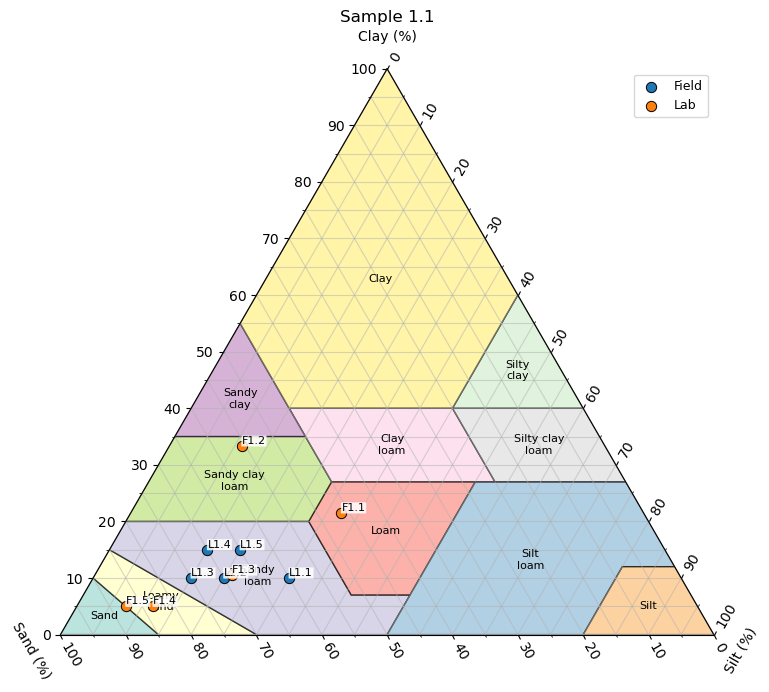

In [138]:
# Choose your input file here
# - Example (uploaded): 'Sample 1.1.xlsx'
# - Or a CSV like: 'my_soils.csv'
title = "Sample 1.1"
DATA_PATH = f'{title}.xlsx'

def main(data_path=DATA_PATH, title=title):
    df = read_soil_file(data_path)
    df = ensure_source_column(df, source_col='Source', name_col='SampleName')

    required = {'Sand', 'Silt', 'Clay'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Need Sand, Silt, Clay.")

    plt.figure(figsize=(8, 7))
    ax = plt.subplot(projection='ternary', ternary_sum=100.0)

    class_paths = plot_soil_texture_classes(ax)

    # Plot each Source in its own color (overall centroid intentionally NOT plotted)
    source_centroids = plot_samples_by_source(
        ax, df,
        source_col='Source',
        name_col='SampleName',
        cmap_name='tab10',
        label_points=True,
        plot_source_centroids=False,  # set True if you want per-source centroid stars
    )

    # Print per-sample classification
    print('--- Sample classifications ---')
    for i, row in df.iterrows():
        s, si, c = float(row['Sand']), float(row['Silt']), float(row['Clay'])
        s_n, si_n, c_n = normalize_to_100([s], [si], [c])
        cls = classify_sample(ax, class_paths, s_n[0], si_n[0], c_n[0])
        name = row['SampleName'] if 'SampleName' in df.columns else f'Sample {i+1}'
        src = row['Source'] if 'Source' in df.columns else 'Unknown'
        print(f"{src} | {name}: Sand={s_n[0]:.1f}, Silt={si_n[0]:.1f}, Clay={c_n[0]:.1f} -> {cls}")

    # Print per-source centroid classification (no overall centroid)
    print('\n--- Per-source centroid (mean) classifications ---')
    for src, (sand_c, silt_c, clay_c) in source_centroids.items():
        cls_c = classify_sample(ax, class_paths, sand_c, silt_c, clay_c)
        print(f"{src} centroid: Sand={sand_c:.1f}, Silt={silt_c:.1f}, Clay={clay_c:.1f} -> {cls_c}")

    # Legend that doesn't widen the figure too much
    ax.legend(loc='upper right', frameon=True, fontsize=9)
    plt.title(title)
    plt.tight_layout()
    plt.show()

main(DATA_PATH, title)


## Notes
- To label each point with `SampleName`, set `label_points=True` in `plot_samples_by_source(...)`.
- To plot a centroid star for each source group, set `plot_source_centroids=True`.
- If your legend is still large, try: `ax.legend(ncol=2, fontsize=8, loc='upper right')`.
